<a href="https://colab.research.google.com/github/bayankh99/HW1/blob/circleci-project-setup/Project_1_Surprisals_and_RTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

The following code provides you with surprisal values for the same data you used in Homework 2.  The surprisal values are based on the output of an RNN model.

We leave it up to you to perform the alignment between the model output and the reading times!

Feel free to skim through the code, it might be helpful for the semi-structured and open-ended tasks!
This includes the package used to train the RNN model, and compute the surprisals - [https://github.com/omershubi/neural-complexity.git](https://github.com/omershubi/neural-complexity.git).

## Set up dependencies and data

Run the cell below to fetch the recurrent neural network codebase we've designed for this assignment.

It will leave the files in a directory called `rnn` (check in the sidebar after you've run the command).

In [ ]:
%%bash
git clone https://github.com/omershubi/neural-complexity.git rnn
mkdir -p rnn/data/ptb

Cloning into 'rnn'...


## Mount Google Drive

We'll save your corpus data, model checkpoints, and output to Google Drive for safekeeping.

Follow the instructions in the output of this command to link your Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

## Upload corpus files for LM training

Here we upload the Penn Treebank corpus files  to the `rnn/data/ptb` folder.
Your files should be named:

- `ptb_tok_train.txt`
- `ptb_tok_dev.txt`

In [ ]:
!wget -qO rnn/data/ptb/ptb_tok_train.txt https://gist.githubusercontent.com/omershubi/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
!wget -qO rnn/data/ptb/ptb_tok_dev.txt https://gist.githubusercontent.com/omershubi/31eff71b74dfb8cfe93d1a9acf8ab523/raw/094d3094b06beb92cd7fd0496710cf43273f8c64/ptb_tok_dev.txt
!cp rnn/data/ptb/* "$GDRIVE_DIR/corpus_data/"

# Recurrent neural network modeling

## Train model

Now we're ready to begin training the model. The below command will launch the neural network optimization procedure, and progressively save checkpoints to the Google Drive you've just mounted. The neural network train for 40 epochs (1 epoch = 1 loop through the training dataset), which should take approximately **2 hours**.

Checkpoints will be saved each time the validation loss improves, and named `ptb_model.pt`. Watch the output of the command below to see how the model's train and validation perplexity improve over time.

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train.txt --validfname ptb_tok_dev.txt

Libraries loaded
| epoch   1 |   200/ 1422 batches | lr 20.00 | ms/batch 17.56 | loss  6.73 | ppl   837.07
| epoch   1 |   400/ 1422 batches | lr 20.00 | ms/batch 13.14 | loss  6.04 | ppl   421.34
| epoch   1 |   600/ 1422 batches | lr 20.00 | ms/batch 11.94 | loss  5.90 | ppl   365.32
| epoch   1 |   800/ 1422 batches | lr 20.00 | ms/batch 12.00 | loss  5.83 | ppl   341.77
| epoch   1 |  1000/ 1422 batches | lr 20.00 | ms/batch 12.00 | loss  5.84 | ppl   342.74
| epoch   1 |  1200/ 1422 batches | lr 20.00 | ms/batch 11.99 | loss  5.78 | ppl   324.46
| epoch   1 |  1400/ 1422 batches | lr 20.00 | ms/batch 12.03 | loss  5.82 | ppl   336.83
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 18.58s | lr: 20.00000000 | valid ppl   270.29
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1422 batches | lr 20.00 | ms/batch 12.13 | loss  5.83 | ppl   339.01
| epoch   

## Compute surprisals

Now we'll compute model surprisals for the text data in `brown.txt` (already downloaded for you). This will output a file called `rnn_surprisals.tsv` to your Google Drive, which you'll use in the next steps of the analysis.

We'll load the checkpoint and use it to extract per-token surprisal estimates.

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


Cool, let's check that the surprisal output looks right. (Compare with the ngram model surprisals from before.)

In [ ]:
import pandas as pd
rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
rnn_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,5.506053,9.515585,0.000000
1,<unk>,0,1,5,6.578504,7.866125,1.649460
2,County,0,2,6,12.514248,6.056062,1.810063
3,<unk>,0,3,5,7.031470,8.524199,0.000000
4,near,0,4,4,13.308077,8.640187,0.000000
...,...,...,...,...,...,...,...
7229,as,363,15,2,6.248776,4.505761,3.256542
7230,a,363,16,1,2.861911,7.777086,0.000000
7231,leader,363,17,6,11.365563,11.206182,0.000000
7232,and,363,18,3,6.632089,5.544580,5.661602


## Harmonize RNN surprisal and RT data

Load and align the reading times with the n-gram model surprisals.
You may load the harmonized csv from Homework 2, or align it again.

Finallyy, align the RNN model-derived surprisal values with human reading times. The harmonize function you wrote in Homework 2 may be helpful here too.

Note, modifications may be required as the tokenization is not necessarily the same as the n-gram model.

In [ ]:
import pandas as pd
import string

def harmonize(rt_data: pd.DataFrame, surprs_data: pd.DataFrame) -> pd.DataFrame:
    def delete_puncs(txt):
        # Remove punctuation from words
        if txt == "<unk>":
            return txt
        for p in string.punctuation:
            txt = txt.replace(p, '')
        return txt

    rt_data_c = rt_data.copy()
    surprs_data_c = surprs_data.copy()

    # Remove unnecessary data from rt_data
    rt_data_c.drop(['subject', 'text_id', 'text_pos', 'word_in_exp', 'time'], axis=1, inplace=True)
    rt_data_c.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

    # Fix words with spaces in rt_data
    rt_data_c['flag_removal'] = rt_data_c['word'].map(lambda w: " " in w)
    rt_data_c['word'] = rt_data_c['word'].apply(lambda w: w.split())
    rt_data_c = rt_data_c.explode('word')

    # Remove punctuation from words
    rt_data_c['word'] = rt_data_c['word'].apply(delete_puncs)

    # Reset index for merging
    rt_data_c.reset_index(drop=True, inplace=True)
    surprs_data_c.reset_index(drop=True, inplace=True)

    # Rename columns in surprs_data_c if necessary
    surprs_data_c.rename(columns={'surp': 'surprisal'}, inplace=True)

    # Merge the datasets
    db_harmon = rt_data_c.merge(surprs_data_c,left_index= True,right_index= True, suffixes = ("_rt", "_surp"))
    db_harmon.drop([ 'sentpos', 'wlen', 'entropy', 'entred'], inplace=True, axis=1)
    db_harmon = db_harmon[db_harmon['flag_removal'] == False]
    db_harmon = db_harmon[db_harmon['word_rt'] != "<unk>"]
    db_harmon = db_harmon[db_harmon['word_surp'] != "<unk>"]
    db_harmon.drop(['flag_removal'], axis=1, inplace=True)

    # Merge with original rt_data to include additional information
    ans = db_harmon.merge(rt_data, on='code')

    return ans



### load the ngram suprisal data and RTs data

In [ ]:
rt_data = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')
rt_data

,word,code,subject,text_id,text_pos,word_in_exp,time
2286,In,17000,s001,0,0,2285,399.90
109460,In,17000,s028,0,0,2503,290.32
50709,In,17000,s014,0,0,1394,501.59
80486,In,17000,s021,0,0,2525,210.93
35626,In,17000,s010,0,0,579,862.35
...,...,...,...,...,...,...,...
79391,captain.,35763,s021,12,763,1430,425.18
116505,captain.,35763,s030,12,763,1489,383.32
26975,captain.,35763,s007,12,763,3426,506.40
15206,captain.,35763,s004,12,763,3528,669.29


In [ ]:

surprisals_ngram = pd.read_csv('https://gist.githubusercontent.com/omershubi/f19f77f5157f7ba7ea1adf72a72847da/raw/d5d553b1217ea70fe3261ce5d9a0532f29769817/5gram_surprisals.tsv', index_col=False, sep='\t')
surprisals_ngram

,sentence_id,token_id,token,surprisal
0,1,1,In,4.57937
1,1,2,<unk>,7.45049
2,1,3,County,12.65410
3,1,4,<unk>,6.11317
4,1,5,near,12.22380
...,...,...,...,...
7693,464,17,a,3.23962
7694,464,18,leader,12.81650
7695,464,19,and,5.90348
7696,464,20,<unk>,4.62292


In [ ]:

# Call the harmonize function to align the data
harmonized_rnn_df = harmonize(rt_data, rnn_surprisals)

# Print the aligned data
harmonized_rnn_df

,word_rt,code,word_surp,sentid,surprisal,word,subject,text_id,text_pos,word_in_exp,time
0,In,17000,In,0,5.506053,In,s001,0,0,2285,399.90
1,In,17000,In,0,5.506053,In,s028,0,0,2503,290.32
2,In,17000,In,0,5.506053,In,s014,0,0,1394,501.59
3,In,17000,In,0,5.506053,In,s021,0,0,2525,210.93
4,In,17000,In,0,5.506053,In,s010,0,0,579,862.35
...,...,...,...,...,...,...,...,...,...,...,...
104133,and,35762,and,363,6.632089,and,s026,12,762,1501,317.57
104134,and,35762,and,363,6.632089,and,s008,12,762,4008,356.46
104135,and,35762,and,363,6.632089,and,s012,12,762,2159,420.24
104136,and,35762,and,363,6.632089,and,s021,12,762,1429,292.40


In [ ]:
harmonized_rnn_df.to_csv(GDRIVE_DIR+"/harmonized_rnn.csv")

# Next Steps

For the next steps, follow the PDF project instructions.

# Structured Tasks


## Compare n-gram and RNN models

### Q1.
**Which model has surprisal estimates which correlate better with human reading times?**


> To determine which model (RNN model or n-gram model) has surprisal estimates that correlate better with human reading times, we  will compare the correlation coefficients between each model's surprisal estimates and the corresponding reading times.
 **The model with a higher correlation coefficient indicates a better correlation with human reading times**

**Load the reading time data**

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# Load the harmonized data containing aligned n-gram and reading time information
harmonized_ngram_df = pd.read_csv(GDRIVE_DIR+"/harmonized_ngram.csv")
harmonized_ngram_df

,Unnamed: 0,code,sentence_id,token,surprisal,word,subject,text_id,text_pos,word_in_exp,time
0,0,17000,1,In,4.57937,In,s001,0,0,2285,399.90
1,1,17000,1,In,4.57937,In,s028,0,0,2503,290.32
2,2,17000,1,In,4.57937,In,s014,0,0,1394,501.59
3,3,17000,1,In,4.57937,In,s021,0,0,2525,210.93
4,4,17000,1,In,4.57937,In,s010,0,0,579,862.35
...,...,...,...,...,...,...,...,...,...,...,...
104133,104133,35762,464,and,5.90348,and,s026,12,762,1501,317.57
104134,104134,35762,464,and,5.90348,and,s008,12,762,4008,356.46
104135,104135,35762,464,and,5.90348,and,s012,12,762,2159,420.24
104136,104136,35762,464,and,5.90348,and,s021,12,762,1429,292.40


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Extract the surprisal estimates and reading times
surprisal_ngram = harmonized_ngram_df['surprisal']
surprisal_rnn = harmonized_rnn_df['surprisal']
reading_times = harmonized_ngram_df['time']

# Calculate the Pearson correlation coefficients
corr_ngram = stats.pearsonr(surprisal_ngram, reading_times)
corr_rnn = stats.pearsonr(surprisal_rnn, reading_times)

print("Correlation between n-gram surprisals and reading times:", corr_ngram.statistic)
print("Correlation between RNN surprisals and reading times:", corr_rnn.statistic)



Correlation between n-gram surprisals and reading times: 0.05477046490265458
Correlation between RNN surprisals and reading times: 0.05708068893623157


based on the above results:
 * we see that the **RNN model  have a slightly stronger correlation with reading times compared to the n-gram model**.

### Q2.
**Plot the relationship between the n-gram model’s surprisal estimate for a word and
the RNN’s estimate. Each point in the graph should correspond to a single token from
the harmonized data. Describe what you see in this graph. Are the models generally
well matched? On what parts of the surprisal spectrum do they disagree?**

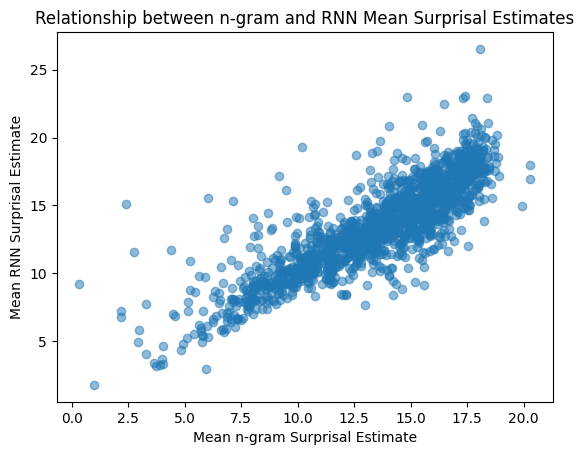

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the mean surprisal for each word in the harmonized n-gram data
mean_surprisal_ngram = harmonized_ngram_df.groupby('word')['surprisal'].mean().reset_index()

# Calculate the mean surprisal for each word in the harmonized RNN data
mean_surprisal_rnn = harmonized_rnn_df.groupby('word_surp')['surprisal'].mean().reset_index()

# Plot the relationship between n-gram and RNN mean surprisal estimates
plt.scatter(mean_surprisal_ngram['surprisal'], mean_surprisal_rnn['surprisal'], alpha=0.5)
plt.xlabel('Mean n-gram Surprisal Estimate')
plt.ylabel('Mean RNN Surprisal Estimate')
plt.title('Relationship between n-gram and RNN Mean Surprisal Estimates')
plt.show()


* From the observation the most of the points in the plot are concentrated around an inclined line resembling y = x (with some scattering), we can infer that the models generally exhibit a positive correlation and are somewhat well matched. This alignment with the diagonal line suggests that there is agreement between the n-gram model's mean surprisal estimates and the RNN model's mean surprisal estimates.


### Q3.
**Pick specific interesting points from this graph (for example, points where the two
models have very different surprisal estimates) and report the sentences containing the
corresponding tokens. Why do you think the models should disagree?**

`we will use   a threshold to select the deviating points that have a variance greater than the threshold (  varianceof the |ngram_surp - rnn_surp|).`


In [ ]:
# Set a threshold to define significant deviation from the diagonal line (using variance as the threshold)
threshold = abs(mean_surprisal_ngram['surprisal'] - mean_surprisal_rnn['surprisal']).var()

# Identify the points with significant deviation
deviating_points = mean_surprisal_ngram[abs(mean_surprisal_ngram['surprisal'] - mean_surprisal_rnn['surprisal']) > threshold]

# Retrieve the corresponding tokens
deviating_tokens = deviating_points['word'].tolist()

# Search for sentences containing the deviating tokens
sentences_with_deviating_tokens = harmonized_rnn_df[harmonized_rnn_df['word'].isin(deviating_tokens)]['sentid'].unique()
deviating_sentences = harmonized_rnn_df[harmonized_rnn_df['sentid'].isin(sentences_with_deviating_tokens)]

grouped_data = deviating_sentences.groupby('sentid')

# Reconstruct the sentences
sentences = []
for sentid, group in grouped_data:
    sentence = ' '.join(group['word'].unique())
    sentences.append(sentence)

# Print the reconstructed sentences
for sentence in sentences:
    print("+", sentence)
    print("-" * len(sentence))


+ In County near the River there is a quiet little suburb by name of which means none residents realize influence their town has had on American military or deeds that have been done in its
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
+ The cry from the lips of a charging was last sound heard on this earth by untold numbers Sioux and Mexican under Japanese in South Chinese North Korean Communists
------------------------------------------------------------------------------------------------------------------------------------------------------------------
+ is the battle cry of U.S. Today a may seem an for in modern de corps has been to organizational charts and
----------------------------------------------------------------------------------------------------------
+ But tell that to a veteran of the especially in on Saturday
----------------

* I think that the models should disagree because they have distinct architectures and underlying assumptions. The n-gram model primarily focuses on local context and frequency-based statistics, while the RNN model takes into account sequential dependencies and captures long-term context. These differences in architecture can lead to variations in how they estimate word surprisal.

* and , I think the choice of tokenization can also contribute to these differences. The n-gram and RNN models utilize different tokenization schemes, which can affect the identification of word boundaries and subsequently influence the estimated surprisal values for specific tokens.

### Q4.
**Examine spillover in both models: look at the relationship between word probability
and the next word’s reading time (a “spillover” effect). Is the effect similar as on the
current word? Bigger? Smaller? Different shape? Are the spillover effects different
across the two models?**

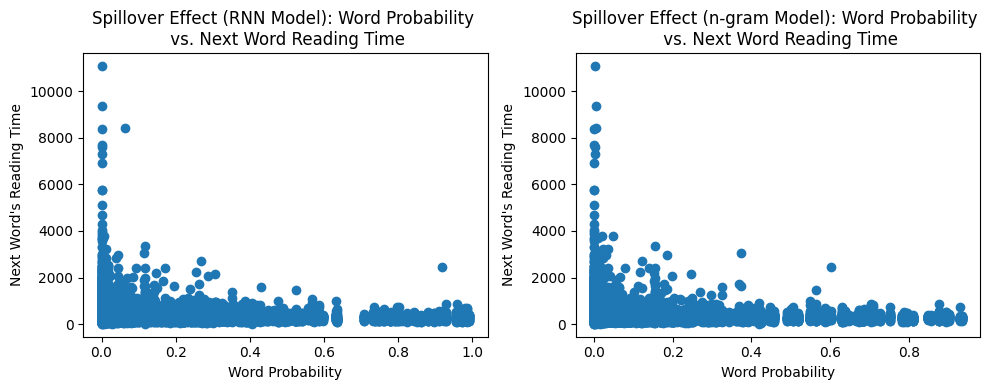

In [ ]:
# Calculate word probability
harmonized_rnn_df['Probability'] = 1 / (2 ** harmonized_rnn_df['surprisal'])
# Shift the reading time to represent the subsequent word's reading time
harmonized_rnn_df['NextWordReadingTime'] = harmonized_rnn_df['time'].shift(-1)
# Calculate word probability
harmonized_ngram_df['Probability'] = 1 / (2 ** harmonized_ngram_df['surprisal'])
# Shift the reading time to represent the subsequent word's reading time
harmonized_ngram_df['NextWordReadingTime'] = harmonized_ngram_df['time'].shift(-1)


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the relationship between word probability and the next word's reading time for RNN model
ax1.scatter(harmonized_rnn_df['Probability'], harmonized_rnn_df['NextWordReadingTime'])
ax1.set_xlabel('Word Probability')
ax1.set_ylabel("Next Word's Reading Time")
ax1.set_title('Spillover Effect (RNN Model): Word Probability \n vs. Next Word Reading Time')

# Plot the relationship between word probability and the next word's reading time for n-gram model
ax2.scatter(harmonized_ngram_df['Probability'], harmonized_ngram_df['NextWordReadingTime'])
ax2.set_xlabel('Word Probability')
ax2.set_ylabel("Next Word's Reading Time")
ax2.set_title('Spillover Effect (n-gram Model): Word Probability \n vs. Next Word Reading Time')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure with both plots
plt.show()



Based on the plots for the RNN and n-gram models, for:

1. **RNN Model**: The plot shows a curve resembling a 1/x function, indicating an inverse relationship between word probability and the reading time of the next word. The points are condensed between the range of 0 to 0.6 on the x-axis, representing the probability range of 0 to 1.0. This suggests that as the word probability decreases (higher surprisal values), the reading time of the subsequent word tends to increase. **The strong spillover effect in this range indicates that word probability has a significant impact on the reading time of the next word in the RNN model.**

2. **n-gram Model**: Similarly, the plot  also shows a curve resembling a 1/x function, indicating an inverse relationship between word probability and the reading time of the next word. However, the points are condensed between the range of 0 to 0.4 on the x-axis, representing the probability range of 0 to 0.9. This suggests that the n-gram model has a narrower range of word probabilities compared to the RNN model. The spillover effect is still significant within this range, indicating that word probability influences the reading time of the next word in the n-gram model.

>**Comparing the spillover effects between the RNN and n-gram models**

>it appears that both models exhibit a similar inverse relationship between word probability and reading time of the next word. However, there are differences in the range of word probabilities where the spillover effect is most pronounced. The RNN model shows a wider range of probabilities (0 to 1.0) with a stronger spillover effect, while the n-gram model has a narrower range (0 to 0.9) but still exhibits a significant spillover effect within that range.


# Semi-structured Tasks
we choose to do this tasks:
* Fit and plot the RT surprisal curve using a General Additive Model (GAM). The
model should include control variables for log-frequency and word length. Examine both current word and spillover effects.

## import the libraries

In [ ]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 54.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load the data

In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
harmonized_rnn_df = pd.read_csv(GDRIVE_DIR+"/harmonized_rnn.csv")
harmonized_rnn_df.head()

,Unnamed: 0,word_rt,code,word_surp,sentid,surprisal,word,subject,text_id,text_pos,word_in_exp,time
0,0,In,17000,In,0,5.506053,In,s001,0,0,2285,399.90
1,1,In,17000,In,0,5.506053,In,s028,0,0,2503,290.32
2,2,In,17000,In,0,5.506053,In,s014,0,0,1394,501.59
3,3,In,17000,In,0,5.506053,In,s021,0,0,2525,210.93
4,4,In,17000,In,0,5.506053,In,s010,0,0,579,862.35


## Compute the log_frequency

In [ ]:
# Downloads ptb_tok_train.txt
!wget -qO ptb_tok_train.txt https://gist.githubusercontent.com/omershubi/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
!echo "Done"

Done


In [ ]:
###TODO: your code here
#calculate log frequencies and add the information as a new column in harmonized_ngram.csv

with open("ptb_tok_train.txt")  as f:
    txtfile = f.read().splitlines()
def add_word(w,dict):
    if w  not  in dict.keys():
        dict[w] = 0
#same function as before
def delete_puncs(txt):
#remove punctions . If the word is unknown keep it.
    if txt=="<unk>":
        return txt
    for p  in string.punctuation:
        txt = txt.replace(p,'')  #remove puncs
    return txt

count_words = {}
for s_  in txtfile:
    s_ = s_.split()
    for w  in s_:
        w = delete_puncs(w)
        count_words.setdefault(w,0)
        count_words[w]+=1
num_of_words = sum(count_words.values())
log_freq = {w:np.log2(c/num_of_words)  for w,c  in count_words.items()}
harmonized_rnn_df['log_freq'] = harmonized_rnn_df['word'].map( lambda w:log_freq[w]  if w  in log_freq.keys()  else 0)
harmonized_rnn_df

,Unnamed: 0,word_rt,code,word_surp,sentid,surprisal,word,subject,text_id,text_pos,word_in_exp,time,log_freq,length
0,0,In,17000,In,0,5.506053,In,s001,0,0,2285,399.90,-9.093451,2
1,1,In,17000,In,0,5.506053,In,s028,0,0,2503,290.32,-9.093451,2
2,2,In,17000,In,0,5.506053,In,s014,0,0,1394,501.59,-9.093451,2
3,3,In,17000,In,0,5.506053,In,s021,0,0,2525,210.93,-9.093451,2
4,4,In,17000,In,0,5.506053,In,s010,0,0,579,862.35,-9.093451,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104133,104133,and,35762,and,363,6.632089,and,s026,12,762,1501,317.57,-5.881377,3
104134,104134,and,35762,and,363,6.632089,and,s008,12,762,4008,356.46,-5.881377,3
104135,104135,and,35762,and,363,6.632089,and,s012,12,762,2159,420.24,-5.881377,3
104136,104136,and,35762,and,363,6.632089,and,s021,12,762,1429,292.40,-5.881377,3


## word length

In [ ]:
# calculate the word-length for each word in the dataset and add this information as a new column in harmonized_ngram.csv
harmonized_rnn_df['length'] = harmonized_rnn_df['word'].map( lambda x:len(x))
harmonized_rnn_df

,Unnamed: 0,word_rt,code,word_surp,sentid,surprisal,word,subject,text_id,text_pos,word_in_exp,time,log_freq,length
0,0,In,17000,In,0,5.506053,In,s001,0,0,2285,399.90,-9.093451,2
1,1,In,17000,In,0,5.506053,In,s028,0,0,2503,290.32,-9.093451,2
2,2,In,17000,In,0,5.506053,In,s014,0,0,1394,501.59,-9.093451,2
3,3,In,17000,In,0,5.506053,In,s021,0,0,2525,210.93,-9.093451,2
4,4,In,17000,In,0,5.506053,In,s010,0,0,579,862.35,-9.093451,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104133,104133,and,35762,and,363,6.632089,and,s026,12,762,1501,317.57,-5.881377,3
104134,104134,and,35762,and,363,6.632089,and,s008,12,762,4008,356.46,-5.881377,3
104135,104135,and,35762,and,363,6.632089,and,s012,12,762,2159,420.24,-5.881377,3
104136,104136,and,35762,and,363,6.632089,and,s021,12,762,1429,292.40,-5.881377,3


## Prepare the data for modeling

In [ ]:
mean_harmonized_rnn_df = harmonized_rnn_df[['code','time','surprisal', 'length', 'log_freq']].groupby('code').mean()
X = mean_harmonized_rnn_df[['surprisal', 'length', 'log_freq']].values
y = mean_harmonized_rnn_df['time'].values

## Define and fit the GAM model, including the control variables and spillover effect:

In [ ]:
gam = LinearGAM(s(0) + s(1) + s(2))
gam.fit(X, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + s(2) + intercept, 
   tol=0.0001, verbose=False)

## Generate the predicted values using the fitted GAM model:

In [ ]:
X_pred = gam.generate_X_grid(term=0, n=100)
y_pred = gam.predict(X_pred)

## Plot the RT surprisal curve using the GAM predictions:

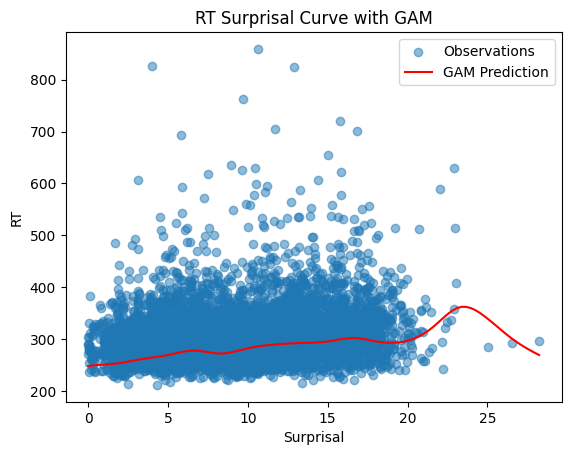

In [ ]:
plt.scatter(mean_harmonized_rnn_df['surprisal'], mean_harmonized_rnn_df['time'], alpha=0.5, label='Observations')
plt.plot(X_pred[:, 0], y_pred, color='red', label='GAM Prediction')
plt.xlabel('Surprisal')
plt.ylabel('RT')
plt.title('RT Surprisal Curve with GAM')
plt.legend()
plt.show()


### Plot the partial dependence for the current word effect and spillover effect:


100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


<Figure size 640x480 with 0 Axes>

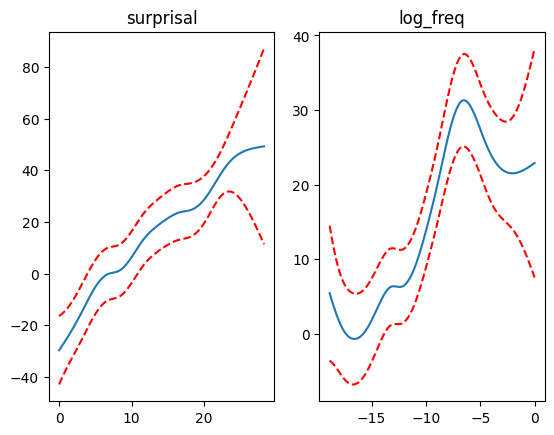

In [ ]:
from pygam import LinearGAM, s
gam = LinearGAM(s(0) + s(1) + s(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,2);

titles = ['surprisal',  'log_freq']
for i, ax in zip([0,2],axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[1 if i==2 else 0]);

For the surprisal plot, the blue curve represents the relationship between the surprisal of the current word and reading time. It indicates that higher surprisal values, suggesting more unexpected or less predictable words, are associated with longer reading times. This demonstrates the substantial influence of the current word's surprisal on reading time. Additionally, the gradual increase in reading time across the range of surprisal values reflects a consistent effect of surprisal on reading time.

Moving to the log_freq plot, the blue curve represents the partial dependence curve for the log_freq variable, which directly affects reading time. The increasing trend from 0 to 30 suggests that higher log_freq values, indicating more frequent words, are associated with longer reading times. However, after 30, very high log_freq values may lead to shorter reading times, potentially due to increased familiarity or ease of processing. The fluctuations in the partial dependence curve for log_freq indicate the noticeable impact of log_freq on reading time. The gaps between the curve and the 95% confidence intervals signify the variability in the spillover effects, which can be influenced by other factors.

Overall, both the current word (surprisal) and spillover (log_freq) have notable impacts on reading time. The current word effect consistently leads to longer reading times with higher surprisal values. In contrast, the spillover effect has a more nuanced relationship with reading time, initially showing a positive effect but potentially reversing at higher log_freq values.

# Open-ended Task

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

Mounted at /content/gdrive


## **Installing all the required dependencies**

In [ ]:
!pip install datasets   emoji
!pip install transformers[torch]
!pip install accelerate -U
!pip install --upgrade openpyxl=='3.0.0'


*   **datasets**: This library is used for working with datasets, such as loading and manipulating data.
*   **numpy (np)**: This library provides support for numerical operations and array manipulation.
*   **pandas (pd)**: This library is used for data manipulation and analysis, particularly for working with tabular data.
*   **torch**: This library is the main PyTorch library for deep learning and provides support for creating and training neural networks.
*   **os**: This library provides functions for interacting with the operating system, such as accessing files and directories.
*   **transformers**: This library is used for working with pre-trained models and tokenizers in natural language processing tasks.











In [ ]:
import datasets
import numpy as np
import pandas as pd
import torch
import os
import transformers
import warnings
warnings.filterwarnings("ignore")

import string
import re
import emoji
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
)
import torch
from transformers import TrainingArguments, Trainer, BertTokenizer,default_data_collator, BertForSequenceClassification, EarlyStoppingCallback

In [ ]:
# Don't forget the class label data
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

## **Emotion Dataset for Emotion Recognition Tasks**

### About Dataset

A dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper below.

The authors constructed a set of hashtags to collect a separate dataset of English tweets from the Twitter API belonging to eight basic emotions, including anger, anticipation, disgust, fear, joy, sadness, surprise, and trust

URL: https://www.kaggle.com/datasets/parulpandey/emotion-dataset

## **Loading the training  dataset.**

the file Training.csv is sotred in the drive

In [ ]:
# Read the training.csv file into a pandas DataFrame
datasets = pd.read_csv(GDRIVE_DIR+"/training.csv")


# Select only the 'text' and 'label' columns from the dataset
datasets = datasets[['text', 'label']]

# Drop all duplicate values based on the 'text' column
datasets.drop_duplicates(subset='text', keep=False, inplace=True)

# Print the length of the dataset after removing duplicates
print(len(datasets))
print("labels",datasets.label.unique())


15938
labels ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


label
anger       2152
fear        1926
joy         5344
love        1289
sadness     4662
surprise     565
dtype: int64


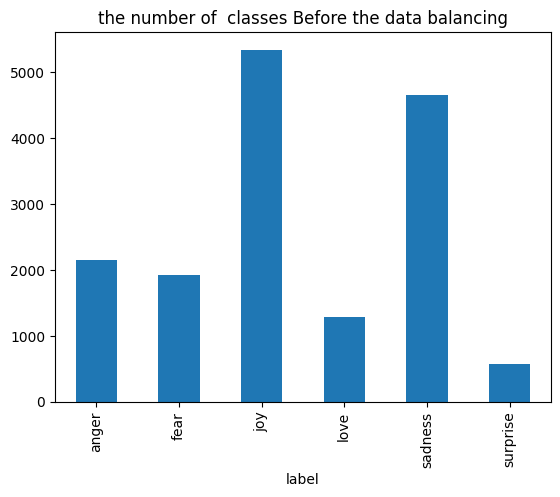

In [ ]:
print(datasets.groupby("label").size())
datasets.groupby('label').size().plot(kind="bar",title="The number of  classes Before the data balancing");


**As shown the labels are not balanced so we need to balance them**

* To balance the labels in the dataset, we can use various techniques such as oversampling or undersampling.
* In our case we will use undersampling technique.
* as we observe the class that has the less samples is `surprise` with `565 samples` which is so small, so we will eleminate this class and we wil not take it in the consideration in the training.



##### data balancing

nbr of samples in the dataset 6445
label
anger      1289
fear       1289
joy        1289
love       1289
sadness    1289
dtype: int64


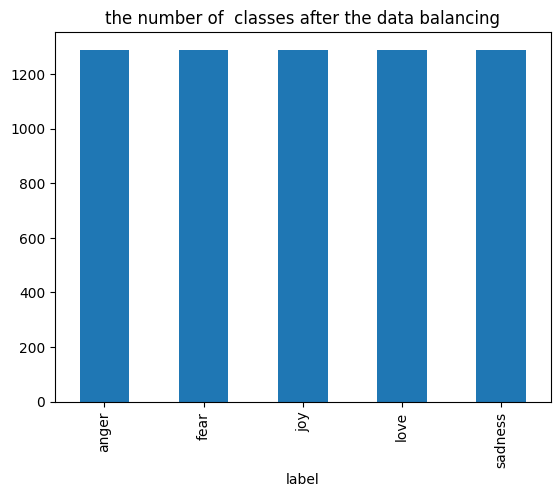

In [ ]:

# keep all the labels  except the label surprise

new_datasets = datasets[ datasets['label'] != "surprise"]

# Count the number of occurrences for each label
label_counts = new_datasets['label'].value_counts()

# Find the minimum count among the labels
min_count = min(label_counts)

# Group the dataset by label
grouped = new_datasets.groupby('label')

# Undersample each group to match the minimum count
balanced_datasets = grouped.apply(lambda x: x.sample(min_count))

# Reset the index of the balanced dataset
balanced_datasets.reset_index(drop=True, inplace=True)

# Print the balanced dataset
print("nbr of samples in the dataset",len(balanced_datasets))
print(balanced_datasets.groupby('label').size())
balanced_datasets.groupby('label').size().plot(kind="bar",title="the number of  classes after the data balancing");

## Data cleaning



In [ ]:
def clean_text(x):
  # Convert emojis to text representation
  x = emoji.demojize(x)

  # Remove '#' and '@' symbols
  x = x.replace('#', '')
  x = x.replace('@', '')

  # Remove special characters and punctuations except for basic ones
  x = re.sub(r"[^A-Z/a-z0-9(),!?\'\`.]", " ", x)

  # Remove leading non-word characters
  x = re.sub(r"^[\W]*", "", x)

  # Replace spaces around non-word characters with a comma
  x = re.sub(r"\s[\W]\s", ", ", x)

  # Split the string into a list of words and remove single characters
  x = [i for i in x.split() if len(i) > 1]

  # Join the list of words back into a string
  x = " ".join(x)

  # Return the cleaned tweet
  return x


In [ ]:
clean_text("@nomi He is very good at it")

'nomi He is very good at it'

In [ ]:
# Drop rows with missing values from the dataset
datasets = datasets.dropna()

# Drop duplicate rows based on the 'text' column
datasets = datasets.drop_duplicates(subset=['text'])

# Apply the 'clean_text' function to the 'text' column of the dataset
datasets['text'] = datasets['text'].apply(clean_text)


## **Convering labels into numbers**

In [ ]:
# Get unique class names from the 'label' column of the dataset
class_names = datasets.label.unique()
print(class_names)

# Function to convert label string to numeric representation
def get_label(label):
    if label == "sadness":
        return 0
    elif label == "joy":
        return 1
    elif label == "love":
        return 2
    elif label == "anger":
        return 3
    elif label == "fear":
        return 4
    elif label == "surprise":
        return 5

# Function to convert numeric label representation to class name
def label2class(label):
    if label == 0:
        return "sadness"
    elif label == 1:
        return "joy"
    elif label == 2:
        return "love"
    elif label == 3:
        return "anger"
    elif label == 4:
        return "fear"
    elif label == 5:
        return "surprise"

# Apply the 'get_label' function to convert label strings to numeric representation
datasets['label'] = datasets.label.apply(get_label)

# Drop rows with missing values (NaN) from the dataset
datasets = datasets.dropna()

# Convert the label column to integer type
datasets['label'] = datasets.label.apply(int)


['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


## load the tokenizer and the pretrained model





In [ ]:
# Define the pretrained tokenizer and model
model_name = "bert-base-cased"
batch_size = 16
max_seq_length = 128

# Create an instance of the BertTokenizer using the pretrained model
tokenizer = BertTokenizer.from_pretrained(model_name, use_fast=True)

# Create an instance of the BertForSequenceClassification model with the specified number of labels
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=6)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

## split the data

In [ ]:
# Extract the 'text' and 'label' columns from the datasets DataFrame into separate lists
X = list(datasets["text"])
y = list(datasets["label"])

# Split the data into training and validation sets using train_test_split
# with a test_size of 0.2, meaning 20% of the data will be used for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## Tokenization

In [ ]:
# Tokenize the training data using the tokenizer
# Apply padding, truncation, and limit the maximum sequence length to 512 tokens
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)

# Tokenize the validation data using the tokenizer
# Apply padding, truncation, and limit the maximum sequence length to 512 tokens
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)


## Create torch dataset

In [ ]:
# Define a custom Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Get the item at the specified index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        # If labels are provided, add them to the item
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])

        return item

    def __len__(self):
        # Return the total number of items in the dataset
        return len(self.encodings["input_ids"])

# Create a training dataset instance of the custom Dataset class
train_dataset = Dataset(X_train_tokenized, y_train)

# Create a validation dataset instance of the custom Dataset class
val_dataset = Dataset(X_val_tokenized, y_val)


## defining the metrics

In [ ]:
# Define a function to compute evaluation metrics
def compute_metrics(p):
    pred, labels = p

    # Compute predicted labels by selecting the class with the highest probability
    pred = np.argmax(pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=labels, y_pred=pred)

    # Calculate recall
    recall = recall_score(y_true=labels, y_pred=pred, average='micro')

    # Calculate precision
    precision = precision_score(y_true=labels, y_pred=pred, average='micro')

    # Calculate F1 score
    f1 = f1_score(y_true=labels, y_pred=pred, average='micro')

    # Return the computed metrics as a dictionary
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


## Define the TrainingArguments

In [ ]:
# Define the training arguments for the Trainer
args = TrainingArguments(
    evaluation_strategy="epoch",                     # Evaluation strategy - evaluate at the end of each epoch
    learning_rate=2e-5,                              # Learning rate for the optimizer
    per_device_train_batch_size=batch_size,           # Batch size for training data
    per_device_eval_batch_size=batch_size,            # Batch size for evaluation data
    num_train_epochs=3,                              # Number of training epochs
    weight_decay=0.01,                               # Weight decay for regularization
    output_dir="/tmp/cls",                           # Directory to save the model checkpoints and outputs
)


## Define the Trainer

In [ ]:
# Create an instance of the Trainer for model training
trainer = Trainer(
    model,                                      # The model to be trained
    args,                                       # Training arguments
    train_dataset=train_dataset,                # Training dataset
    eval_dataset=val_dataset,                   # Evaluation dataset
    data_collator=default_data_collator,        # Data collator for batch processing
    tokenizer=tokenizer,                        # Tokenizer for encoding inputs
    compute_metrics=compute_metrics             # Function for computing evaluation metrics
)


### start the training

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.705800,0.202696,0.917503,0.917503,0.917503,0.917503
2,0.156300,0.171326,0.924404,0.924404,0.924404,0.924404
3,0.108800,0.182190,0.932873,0.932873,0.932873,0.932873


TrainOutput(global_step=2391, training_loss=0.2633486284665212, metrics={'train_runtime': 690.6221, 'train_samples_per_second': 55.385, 'train_steps_per_second': 3.462, 'total_flos': 1788782611707000.0, 'train_loss': 0.2633486284665212, 'epoch': 3.0})

### save the model

In [ ]:
saved_model_local_path = GDRIVE_DIR+"/model"

In [ ]:
trainer.save_model(saved_model_local_path)

## evaluate the model

In [ ]:
# Evaluate the trained model using the evaluation dataset
history = trainer.evaluate()
print(history)

{'eval_loss': 0.18219029903411865, 'eval_accuracy': 0.9328732747804266, 'eval_precision': 0.9328732747804266, 'eval_recall': 0.9328732747804266, 'eval_f1': 0.9328732747804266, 'eval_runtime': 13.5533, 'eval_samples_per_second': 235.219, 'eval_steps_per_second': 14.757, 'epoch': 3.0}


## prediction

In [ ]:
# Tokenize the test data using the tokenizer
text = ['i am happy', 'i am sad', "i love you","what are you doing here!"]
X_test_tokenized = tokenizer(text, padding=True, truncation=True, max_length=512)

# Create a torch dataset for the test data
test_dataset = Dataset(X_test_tokenized)

# Load the trained model from the saved model path
# model_path = "sentiment_model"
model = BertForSequenceClassification.from_pretrained(saved_model_local_path, num_labels=6)

# Create a test trainer with the loaded model
test_trainer = Trainer(model)

# Make predictions on the test dataset
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess the raw predictions by selecting the class with the highest probability
y_pred = np.argmax(raw_pred, axis=1)

# Iterate through the predicted labels and corresponding sentences
for l, t in zip(y_pred, text):
    # Print the classification result for each sentence
    print(f"The sentence '{t}' is classified as '{label2class(l)}'")


The sentence 'i am happy' is classified as 'joy'
The sentence 'i am sad' is classified as 'sadness'
The sentence 'i love you' is classified as 'love'
The sentence 'what are you doing here!' is classified as 'anger'


# Export to PDF

In [ ]:
!wget -nc https://raw.githubusercontent.com/scaperex/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
# If you saved the notebook in the default location in your Google Drive,
# and didn't change the name of the file, the code should work as is. If not, adapt accordingly.
# E.g. in your case the file name may be "Copy of XXXX.ipynb"
colab_pdf(file_name='Copie de Project 1: Surprisals and RTs.ipynb', notebookpath="/content/drive/MyDrive/Colab Notebooks")

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Copie de Project 1: Surprisals and RTs.ipynb to pdf
/usr/local/lib/python3.10/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  warn(
[NbConvertApp] Support files will be in Copie de Project 1: Surprisals and RTs_files/
[NbConvertApp] Making directory ./Copie de Project 1: Surprisals and RTs_files
[NbConvertApp] Making directory ./Copie de Project 1: Surprisals and RTs_files
[NbConvertApp] Making directory ./Copie de Project 1: Surprisals and RTs_files
[NbConvertApp] Making directory ./Copie de Project 1: Surprisals and RTs_files
[NbConvertApp] Making directory ./Copie de Project 1: Surprisals and RTs_files
[NbConvertApp] Making directory ./Copie de Project 1: Surprisals and RTs_files
[NbConvertApp] Writing 210077 bytes to no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'